# <div align="center"> Data Science for Social Scientists  </div>
### <div align="center"> ECO 4199 </div>
#### <div align="center">Class 5 - Classification</div>
### <div align="center"> 12 October 2021 </div>

<div align="center"> Fabien Forge, (he/him)</div>

# Mixing quantitative and qualitative

$$ Y = f(\mathbf{X}) + \varepsilon$$

- Last class we saw only instances of quantitative variables, both for our __predictors__ X and the __target__ Y
- In the multiple regression model, we assumed that TV and Radio ads have an __additive effect__
    - Remember from econometrics that this gives you the effect of TV on Sales, __holding Radio constant__
    - In other words, the effect of TV ads is assumed to be the same, regarless of how much you spend on Radio ads
- Today, we will explore new variable types and more richful models

# New data set
- Remember that we are still using the book [Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/)
- I will sometimes use code is coming from this [set of scripts](https://github.com/JWarmenhoven/ISLR-python)
- We will also use the <span style="color:orange;">Credit dataset</span> from the R package ISLR or on the [book's webpage](https://www.statlearning.com/resources-first-edition)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as skl_lm

import math

folderPath="~/Dropbox/Data Science for Social Scientists/Fall 2021/Lectures/Class 5 - Classification"

In [2]:
credit=pd.read_csv('/'.join([folderPath, 'Credit.csv']), usecols=list(range(1,12)))
display()
display(credit.info())
display(credit.describe())
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


None

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Let's inspect this dataset visually

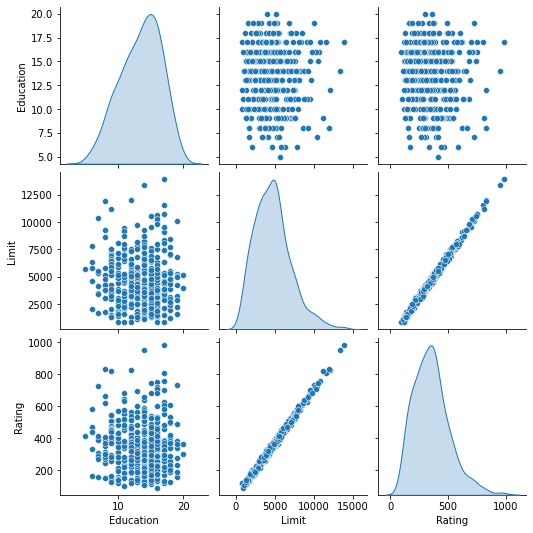

In [3]:
sns.pairplot(credit[['Education','Limit','Rating']],diag_kind="kde")
#txt="\nEach panel of the figure above is a scatterplot for a pair of variables whose identities are given by the corresponding row and column labels.\nFor example, the scatterplot directly to the right of the $\it{Balance}$ histogram depicts balance versus age, \nwhile the plot directly to the right of $\it{Age}$ corresponds to age versus cards."
#plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

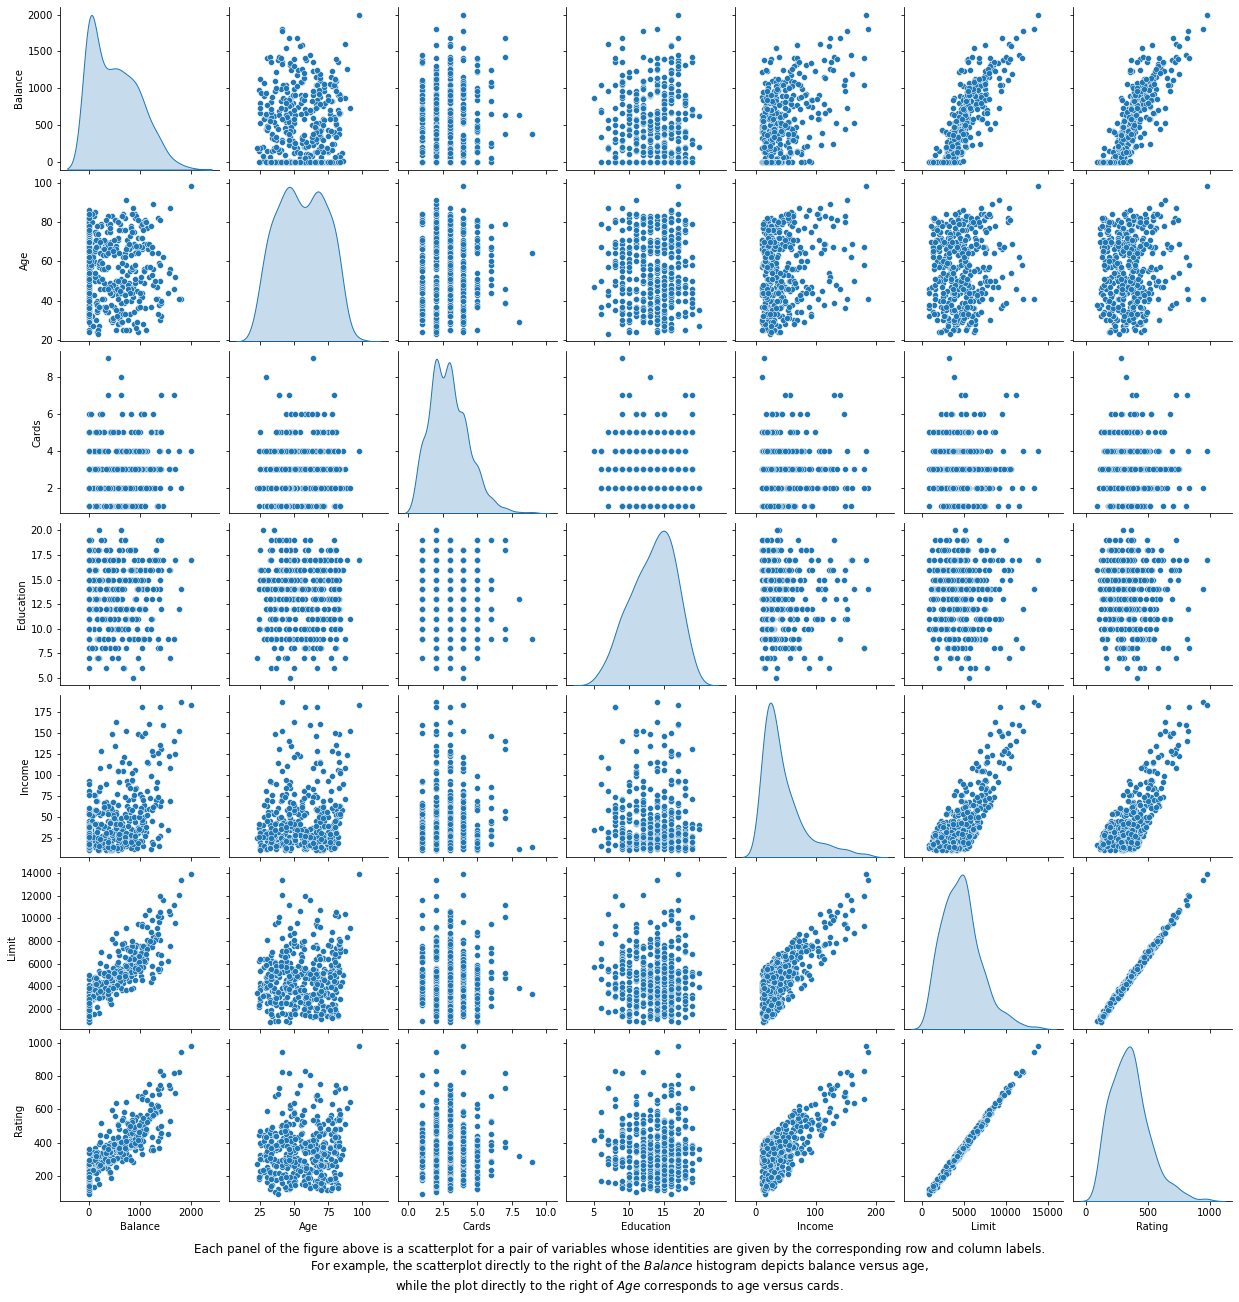

In [4]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']],diag_kind="kde")
txt="\nEach panel of the figure above is a scatterplot for a pair of variables whose identities are given by the corresponding row and column labels.\nFor example, the scatterplot directly to the right of the $\it{Balance}$ histogram depicts balance versus age, \nwhile the plot directly to the right of $\it{Age}$ corresponds to age versus cards."
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## The statistical task at hand
Our credit dataset records:
- _balance_(average credit card debt for a number of individuals) 
- __quantitative predictors__: 
    - age, cards (number of credit cards), education(years of education), income (in thousands of dollars), limit(credit limit), and rating (credit rating). 
-  __qualitative variables__: 
    - gender, student (student status), status (marital status), and ethnicity (Caucasian, African American or Asian).

# Dummy variables

- Suppose we are interested in knowing how credit card balance differ between males and females, ignoring the other variables for the moment. 
- A qualitative predictor (__factor__) with only 2 levels can be easily integrated to a regression
    - Create an indicator or __dummy variable__ that takes on two possible numerical values. For example, based on the gender variable, we can create variable
$$
x_i=
\begin{cases}
1,\ \  \text{if the ith person is female}\\
0,\ \  \text{if the ith person is male}
\end{cases}
$$

Which yields the following population model:
$$
y_i= \beta_0 + \beta_1 x_i + \varepsilon_i =
\begin{cases}
\beta_0 + \beta_1 x_i + \varepsilon_i ,\ \  \text{if the ith person is female}\\
\beta_0 + \varepsilon_i ,\ \  \text{if the ith person is male}
\end{cases}
$$

## Before we move on
- I follow closely the ISLR book and gender modelled as 1/0 is a classical example in statistics.
- There are still 2 issues about this:
    1. The binary representation of gender is clearly dubious
    2. The use of gender or race can be problematic when looking at predictive tasks

- Remember that our task is to predict credit card balance based on some observables
    - The risk is high that if we use identity variables to do so our models will predict that middle-aged white males are the ideal client for a bank
    - This would perpetuate and reinforce inequalities
- This is a very important subject. This is why we will discuss this specifically during our last lecture, once we know more about prediction.

In [5]:
# Replace Gender by a dummy variable
print("Before")
display(credit.head())
credit['Gender']=credit['Gender'].str.replace(" ","") # remove spaces in the string
credit['Gender']=pd.to_numeric(credit.Gender.replace({"Male":0, "Female":1})).astype(np.int8) # encode
print("After")
credit.head()

Before


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


After


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,0,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,1,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,0,No,No,Asian,580
3,148.924,9504,681,3,36,11,1,No,No,Asian,964
4,55.882,4897,357,2,68,16,0,No,Yes,Caucasian,331


In [6]:
# Regress Sales on a constant term and TV
results = smf.ols('Balance ~ Gender ', data=credit).fit()
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1836
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.669
Time:                        10:15:56   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    509.8031     33.128     15.389      0.0

## Interpreting dummy variables

- $\hat{β}_0$ (\$509) is average credit card balance among males
- $\hat{β}_0 + \hat{β}_1$ (\$530) is the average credit card balance among females, and 
- $\hat{β}_1$ (\$20) is the difference, on average, in credit card balance between females and males.
- Question: are women running larger credit card balance than men?

- The p-value for the dummy variable is very high. 
    - No statistical evidence of a difference in average credit card balance between the genders.

# Qualitative Predictors with More than Two Levels

- If you have more than 2 categories
- For example, for the ethnicity variable we can create two dummy variables:

$$
x_{i1}=
\begin{cases}
1,\ \  \text{if the ith person is Asian}\\
0,\ \  \text{if the ith person is not Asian}
\end{cases}
$$
and
$$
x_{i2}=
\begin{cases}
1,\ \  \text{if the ith person is Caucasian}\\
0,\ \  \text{if the ith person is not Caucasian}
\end{cases}
$$

$$y_i = β_0+β_1x_{i1}+β_2x_{i2}+\varepsilon_i =
\begin{cases}
β_0+β_1x_{i1}+\varepsilon_i\ \ \ , \text{if the ith person is Asian}\\
β_0+β_2x_{i2}+\varepsilon_i\ \ \ , \text{if the ith person is Caucasian} \\
β_0+\varepsilon_i\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ , \text{if the ith person is African American} 
\end{cases}
$$

- $β_0$ is the average credit card balance for African Americans
- $β_1$ is the difference in the average balance between the Asian and African American categories
- $β_2$ is the difference in the average balance between the Caucasian and African American categories


- To avoid __multicolinearity__ there should be an omitted category. 
- The level with no dummy variable (African American) in this example is also known as the __baseline__.

In [7]:
# Regress Sales on a constant term and Ethnicity -- THE EASY WAY
results = smf.ols('Balance ~ Ethnicity ', data=credit).fit() # smf understands to use Ethnicity as a categorical variable and drops the first category as baseline
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04344
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.957
Time:                        10:15:56   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6045.
Df Residuals:                     397   BIC:                             6057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                531

In [8]:
# Regress Sales on a constant term and Ethnicity -- THE EXPLICIT WAY
dummies=pd.get_dummies(credit['Ethnicity'], drop_first=True) # create dummies and drop the omitted category
display(dummies.head())
df=credit.join(dummies)

results = smf.ols('Balance ~ Asian + Caucasian ', data=df).fit() # pass the dummies explicitly
# Inspect the results
print(results.summary())

,Asian,Caucasian
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04344
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.957
Time:                        10:15:56   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6045.
Df Residuals:                     397   BIC:                             6057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    531.0000     46.319     11.464      0.0

In [9]:
# Regress Sales on a constant term and Ethnicity -- THE MULTICOLINEARITY AWARE WAY
dummies=pd.get_dummies(credit['Ethnicity'], drop_first=False) # create dummies with no omitted category
dummies.columns=dummies.columns.str.replace(" ","")
display(dummies.head())
df=credit.join(dummies)

results = smf.ols('Balance ~ AfricanAmerican+ Asian + Caucasian -1', data=df).fit() # -1 indicates to drop the intercept
# Inspect the results
print(results.summary())

,AfricanAmerican,Asian,Caucasian
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1


                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04344
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.957
Time:                        10:15:56   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6045.
Df Residuals:                     397   BIC:                             6057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
AfricanAmerican   531.0000     46.319     

# Removing the Additive Assumption

- Last week we used the <span style="color:orange;">Advertising</span> dataset
- In the multiple regression model we saw that both TV and radio were associated with sales. 
- We also assumed that TV and Radio effects were indepent from one another
    - Using the old terminology, we captured the effect of TV ads on Sales keeping radio constant


## Interaction effect

- Suppose that spending money on radio ads actually increases the effectiveness of TV ads
    - This means that slope for TV should increase as radio spending increases.
- If true, for a given budget, spending half on radio and half on TV may increase sales more than allocating the entire amount to either TV or to radio. 
- This is an interaction effect 

## Interaction term
- Instead of running:
$$Y_i = β_0 + β_1 \text{TV}_i + β_2 \text{Radio}_i+ \varepsilon_i$$
- We could interact TV and radio using an __interaction term__:
$$Y_i = β_0 + β_1 \text{TV}_i + β_2 \text{Radio}_i+ β_3 \text{Radio}_i\times\text{TV}_i+ \varepsilon_i$$


## Interaction term - continued
- Note that we can rewrite the last equation as:
$$Y_i = β_0 + \underbrace{(β_1 + β_3 \text{Radio}_i)}_{\tilde{β}_1} \text{TV}_i + β_2 \text{Radio}_i+ \varepsilon_i$$


$$Y_i = β_0 + \tilde{β}_1 \text{TV}_i + β_2 \text{Radio}_i+ \varepsilon_i$$

- Since $\tilde{β}_1$ changes with Radio, the effect of TV on Y is
no longer constant 
    - adjusting Radio will change the impact of TV on Y
    - $β_3$ is the change in the effect of TV ads on Sales when Radio increases by one
    - $β_1$ is now the effect of TV ads on Sales when Radio ads equal zero

In [10]:
ads=pd.read_csv('/'.join([folderPath, 'Advertising.csv']), usecols=[1,2,3,4])

print("***Additive Model***")
results = smf.ols('Sales ~ TV + Radio ', data=ads).fit()
print(results.summary())

***Additive Model***
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           4.83e-98
Time:                        10:15:57   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.29

In [11]:
print("***Model with Interaction Term***")
results = smf.ols('Sales ~ TV + Radio + TV*Radio', data=ads).fit() 
# Inspect the results
print(results.summary())

***Model with Interaction Term***
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):          6.68e-146
Time:                        10:15:57   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7

## Interpretation of the results
-  $\hat{β}_1 \text{and} \hat{β}_2$ give what's known as the __main effect__
- $\hat{β}_3$ is significant and implies that:
    - an increase in TV advertising of 1,000 dollars is associated with increased sales of ($\hat{β}_1+ \hat{β}_3\times $ radio) ×1,000 =19+1.1×radio units. 
    - an increase in radio advertising of \\$1,000 will be associated with an increase in sales of ($\hat{β_2} + \hat{β}_3 \times $ TV) × 1,000 = 29 + 1.1 × TV units.

## Models' performance
- We now have two models that include the same number of predictor variables (TV and Radio)
- But the second model allows for synergies between Radio and TV
- The $R^2$ for our model is 96.8%, compared to only 89.7% for the additive model
    -  This means that (96.8 − 89.7)/(100 −89.7) = 69% of the variability in sales that remains after fitting the additive model has been explained by the interaction term.
    - This interaction term has greatly improved our predictive power!

In [29]:
b=89.7
a=96.8
change_in_r2=(a - b)/(100-b)*100
print(f" Additional variance explained by your new model is: {round(change_in_r2,1)}%")

 Additional variance explained your new model is: 68.9%


# Classification
- Qualitative variables need not be used only as predictors
- In many interesting predictive tasks, the response variable is qualitative
- Predicting a __categorical variable__ (two or more levels), is a process known as __classification__ 

## Linear probability model
- The simplest way to perform classification with a categorical variable (2 levels) is to use the __linear probability model__ (LPM)
- In the LPM, you regress a dummy variable on your regressors:
\begin{equation*}
Y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + ... + \beta_k X_{ki} + \varepsilon_i
\end{equation*}


- The population regression function is defined by the expected value of the dependent variable given each set of possible values of the regressors:
\begin{equation*}
E(Y | X_1, X_2, ..., X_k) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k
\end{equation*}

Question: why was $\varepsilon_i$ in the population regression but not in the expectation?

## From expectation to mean to probability

- The expectation in the population corresponds to the sample mean
- If a random variable can take only two values (0, 1) then its mean will also be between 0 and 1
    - Mean of [0,0,0] is $\frac{1}{3} \times (0 + 0 + 0) = \frac{0}{3} = 0$
    - Mean of [1,1,1] is $\frac{1}{3} \times (1 + 1 + 1) = \frac{3}{3} = 1$
- If $Y$ is a dummy variable, then its expected value is the same as the probability that Y is equal to 1
- So in this case, the population regression function is:
\begin{equation*}
P(Y = 1 | X_1, X_2, ..., X_k) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k
\end{equation*}



In [13]:
df = pd.read_excel('/'.join([folderPath, 'Default.xlsx']),index_col=0)

# # Note: factorize() returns two objects: a label array and an array with the unique values.
display(df.default.factorize())
# # We are only interested in the first object. 
df.rename(columns={"default":"default_lab","student":"student_lab" },inplace=True)
df.loc[:,'default'] = df.default_lab.factorize()[0] 
df['student'] = df.student_lab.factorize()[0]
df.head()

/Users/forgef/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(array([0, 0, 0, ..., 0, 0, 0]), Index(['No', 'Yes'], dtype='object'))

,default_lab,student_lab,balance,income,default,student
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


In [14]:
results = smf.ols('default ~ balance', data=df).fit() 
# Inspect the results
print(results.summary())
balance=1000
print("\n\n******")
print(f"An increase in the credit card by ${balance:,} is associated with, on average, \
an increase in the probability of default by {round(results.params['balance']*balance*100,3)} percentage points.")


                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1397.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):          2.77e-286
Time:                        10:15:58   Log-Likelihood:                 3644.8
No. Observations:               10000   AIC:                            -7286.
Df Residuals:                    9998   BIC:                            -7271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0752      0.003    -22.416      0.0

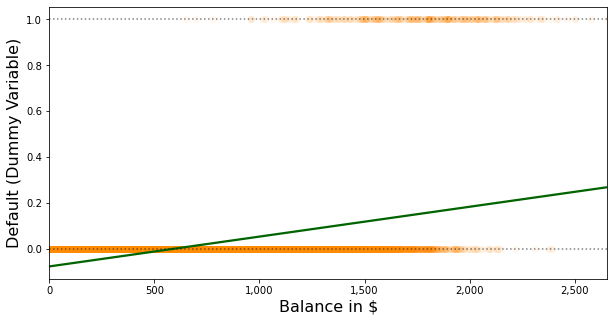

In [15]:
fig, ax= plt.subplots(1,1,figsize=(10,5))

ax = sns.regplot(x="balance", y="default", data=df, ci=None,scatter_kws={'alpha':.05, 'color':'darkorange','marker':'*'},line_kws={ 'color':'darkgreen'})
ax.get_xaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.axhline(0, color='k', ls=":",alpha=0.5)
ax.axhline(1, color='k', ls=":",alpha=0.5)

ax.set_xlabel("Balance in $", fontsize=16)
ax.set_ylabel("Default (Dummy Variable)", fontsize=16)
plt.show()

# What's wrong with the linear probability model?
- The relationship we estimated seems intuitive:
    - As balance increases the probability of defaulting increases (linearly).
- But remember that we now care more about our ability to predict the probability of defaulting
    - Obviously our $R^2$ is not fantastic but both our parameters are significant at the 1\% level 
    - More importantly, think about the values $\hat{Y}_i$ can take

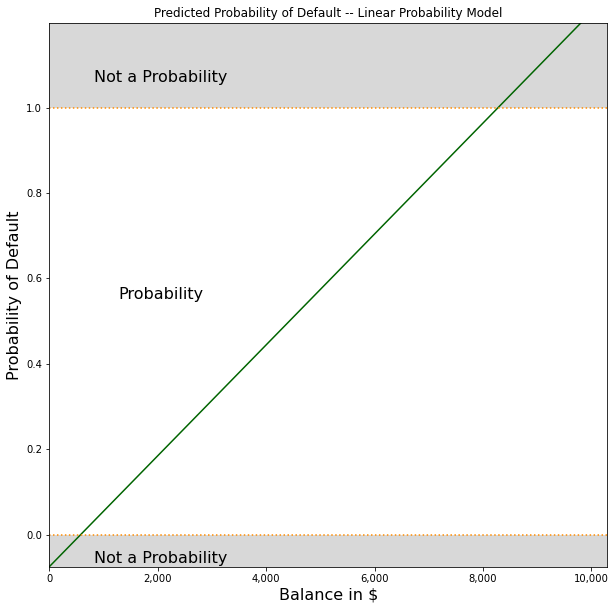

In [16]:
balance=[bal for bal in np.arange(0,10000, 200)]
df_hat=pd.DataFrame(data={'intercept':results.params['Intercept'], 'slope':results.params['balance'], 'balance':balance})
df_hat['Predicted Probability of Default']=df_hat['intercept'] + df_hat['slope']*df_hat['balance']
fig, ax=plt.subplots(1,1,figsize=(10,10))

sns.lineplot(data=df_hat, x="balance", y="Predicted Probability of Default", ax=ax, color='darkgreen')

ax.set_xlim(left=0)
ax.set_ylim(bottom=df_hat['Predicted Probability of Default'].min() , top=df_hat['Predicted Probability of Default'].max())

ax.get_xaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_xlabel("Balance in $", fontsize=16)
ax.set_ylabel("Probability of Default", fontsize=16)

ax.axhline(0, color='darkorange', ls=":")
ax.axhline(1, color='darkorange', ls=":")

ax.set_title("Predicted Probability of Default -- Linear Probability Model")

plt.axhspan(0, df_hat['Predicted Probability of Default'].min(), facecolor='0.5', alpha=0.3)
plt.axhspan(1, df_hat['Predicted Probability of Default'].max(), facecolor='0.5', alpha=0.3)

plt.text(0.2, 0.5, 'Probability',fontsize=16, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.text(0.2, .9, 'Not a Probability',fontsize=16, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.text(0.2, .015, 'Not a Probability',fontsize=16, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.show()

# Finding the right function
- Remember that our goal is to first find the correct function linking X to Y in the population 
$$Y = f(\mathbf{X}) + \varepsilon$$
- It seems that a linear function is bound to fail if the response variable is qualitative
- In our example, even reasonable support yields predicted probability below 0 and above 1
    - a support is the __range of values__ over which we use our function
- Ideally, we would want to find a function which would predict a probability between 0 and 1 even if we use extravagant values as input (e.g -50,000 or 2 million balances)
- It turns out, cumulative distribution functions fit this description

# Logistic Function
- The most used cummulative distribution function is the standard logistic function:
$$f(X) = \frac{e^x}{1+e^x}$$
- This function has a useful property for us:
    - As $x \to -\infty$, $\frac{e^x}{1+e^x} \to 0$
    - As $x \to +\infty$, $\frac{e^x}{1+e^x} \to 1$

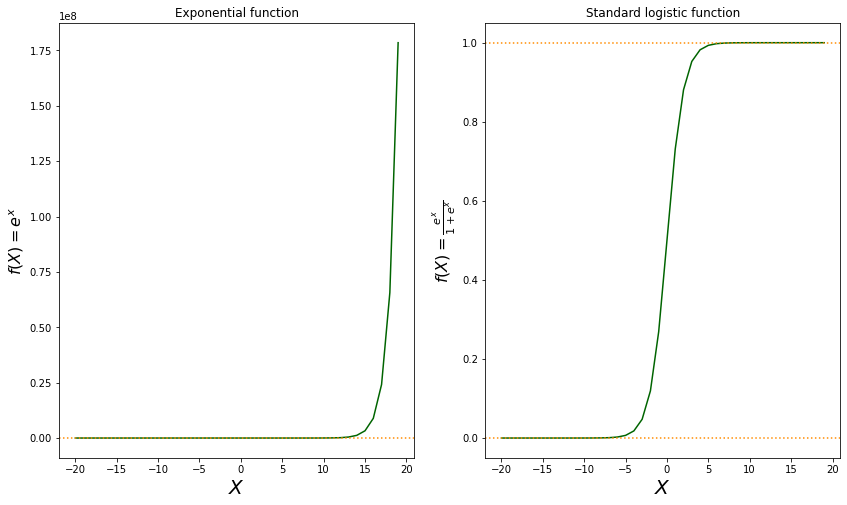

In [17]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

X=[x for x in np.arange(-20,20,1)]
Y1=[math.exp(x) for x in X ]
Y2=[math.exp(x)/(1+math.exp(x)) for x in X ]

sns.lineplot( x=X, y=Y1 ,ax=axes[0], color='darkgreen')
sns.lineplot( x=X, y=Y2 ,ax=axes[1], color='darkgreen')

axes[0].set_xlabel(r"$X$", fontsize=20)
axes[0].set_ylabel(r"$f(X) = e^x$", fontsize=16)
axes[0].set_title("Exponential function")
axes[0].axhline(0, color='darkorange', ls=":")


axes[1].set_xlabel(r"$X$", fontsize=20)
axes[1].set_ylabel(r"$f(X) = \frac{e^x}{1+e^x} $", fontsize=16)
axes[1].set_title("standard logistic function".capitalize())
axes[1].axhline(0, color='darkorange', ls=":")
axes[1].axhline(1, color='darkorange', ls=":")

plt.show()

## From Logistic Function to Logistic Regression

- We need to transform our logistic function to a __logistic regression__:
    - Note that probability of default given balance can be written as
        - Pr(default = Yes|balance)
        - You read it as the probability (Pr) of defaulting ("default=Yes") given that ("|") balance is a given value
    - Unlike the linear probability model, Pr(default = Yes|balance) will range between 0 and 1. 
    - Then for any given value of balance, a prediction can be made for default. 
$$Pr(Y=1 | X) = p(X) = \Large\frac{e^{\beta_0 + \beta_1x}}{1+e^{\beta_0 + \beta_1x}} $$


## Logit (tl;dr)
After a bit of algebra (that you don't need to know about) we can rewrite the logistic regression:
$$ p(X) = \Large\frac{e^{(\beta_0 + \beta_1X)}}{1+e^{(\beta_0 + \beta_1X)}} $$

as

$$ \underbrace{\frac{p(X)}{1-p(X) }}_{odds} = \Large e^{(\beta_0 + \beta_1X)} $$
- e.g. $p(X) = 0.2$ implies odds of $\frac{0.2}{1-0.2} = \frac{1}{4}$
    
taking log of both sides yields:
$$ \underbrace{\log (\frac{p(X)}{1-p(X) })}_{\text{log-odds}} = \beta_0 + \beta_1X $$


## Interpreting $\beta_1$
$$ \underbrace{\log (\frac{p(X)}{1-p(X) })}_{\text{log-odds or logit}} = \beta_0 + \beta_1X $$

- Recall from last class that in a linear regression model $β_1$ gives:
    - _the average change in Y associated with a one-unit increase in X_ 
- In a logistic regression model, increasing X by one unit changes:
    - the log-odds by $β_1$, or equivalently it multiplies the odds by $e^{β_{1}}$
    - the relationship between $X$ and $p(X)$ is not a straight line: $β_1$ does __not__ correspond to the change in $p(X)$ associated with a one-unit increase in $X$.
    - The amount that $p(X)$ changes due to a one-unit change in X depends on the current value of X.

## Logistic Regression - Estimation

- As per the OLS regression, the goal is to find the $\hat{\beta}_0$ and $\hat{\beta}_1$ that provide the best fit of the data.
- This is done using __maximum likelihood estimation__ (MLE)
    - We won't explain MLE method now, the solution is more technical than OLS
    - But MLE follows the same logic:
        - Try to find $\hat{\beta}_0$ and $\hat{\beta}_1$ such that plugging these estimates into the model for p(X),  yields a number close to one for all individuals who defaulted, and a number close to zero for all individuals who did not.

Example using [Scikit Learn's Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [18]:
%%capture --no-stdout 
# hide warnings from sklearn

# Logistic regression using sklearn
print("Shape {} and type {} before.".format(df.balance.shape, type(df.balance)))
X_train = df.balance.values.reshape(-1,1) # store the balance variable (our predictor) to a numpy array
print("Shape {} and type {} after.".format(X_train.shape, type(X_train)))
y = df.default # Store the target variable in y

# Calculate the classification probability and predicted classification.
clf = skl_lm.LogisticRegression(solver='newton-cg') # instantiate a logistic regression class
clf.fit(X_train,y) # fit the data using this class

# Summary of the results
beta_0= clf.intercept_[0] ; beta_1=clf.coef_[0][0]
print('\n\nsklearn function used: ',clf)
print('classes (unique values for Default): ',clf.classes_)
print('\u03B2\u0302\u2080:',beta_0)
print('\u03B2\u0302\u2081:',beta_1)

Shape (10000,) and type <class 'pandas.core.series.Series'> before.
Shape (10000, 1) and type <class 'numpy.ndarray'> after.


sklearn function used:  LogisticRegression(solver='newton-cg')
classes (unique values for Default):  [0 1]
β̂₀: -10.651330191051779
β̂₁: 0.005498916667832132


## New prediction

- We now have parameter values that can be used to predict the probability of default given balance.
- Our predicted probability will thus follow:

$\hat{Pr}(Y=1 | X) = \hat{p}(X) = \Huge\frac{e^{\hat{\beta}_0 + \hat{\beta}_1x}}{1+e^{\hat{\beta}_0 + \hat{\beta}_1x}} = \Huge\frac{e^{-10.7 + 0.005\times x}}{1+e^{-10.7  + 0.005\times x}} $


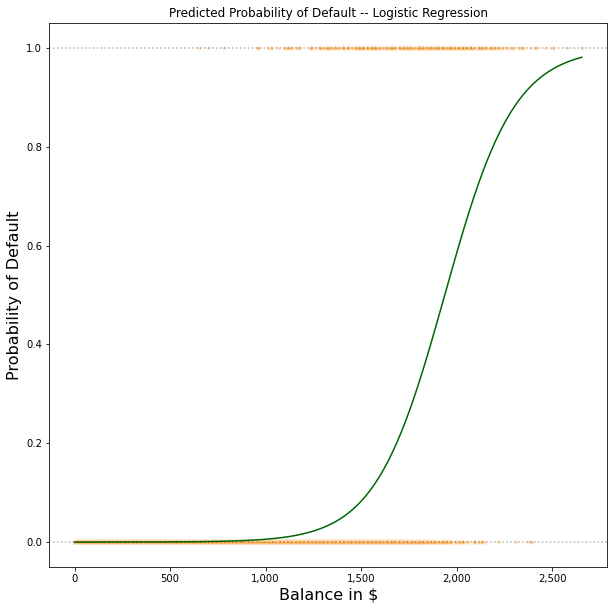

In [19]:
# Plot the predicted default against the actual data

balance=[bal for bal in np.arange(df.balance.min(), df.balance.max())]
df_hat=pd.DataFrame(data={'intercept':beta_0, 'slope':beta_1, 'balance':balance})
# Predict using the logistic function formula
df_hat['Predicted Probability of Default']=np.exp(df_hat['intercept'] + df_hat['slope']*df_hat['balance']) /(1+  np.exp(df_hat['intercept'] + df_hat['slope']*df_hat['balance']))

df_hat.head()
# initiate plot
fig, ax=plt.subplots(1,1,figsize=(10,10))
# plot actual datapoints
sns.scatterplot(x="balance", y="default", data=df, ax=ax,alpha=.3, color='darkorange', marker='*')
# plot y hat, the predicted probability of default from our estimated model
sns.lineplot(data=df_hat, x="balance", y="Predicted Probability of Default", ax=ax, color='darkgreen')

ax.get_xaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.axhline(0, color='k',alpha=.3, linestyle=":")
ax.axhline(1, color='k',alpha=.3, linestyle=":")

ax.set_xlabel("Balance in $", fontsize=16)
ax.set_ylabel("Probability of Default", fontsize=16)
ax.set_title("Predicted Probability of Default -- Logistic Regression")
plt.show()

In [20]:
est = smf.logit('default ~ balance' , data=df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Oct 2021   Pseudo R-squ.:                  0.4534
Time:                        10:15:59   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                6.233e-290
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0

# Assessing the Accuracy of the Coefficient Estimates
- Many aspects of the logistic regression output shown above are similar to the linear regression output from last week. 
- Estimated parameters also have standard errors. 
- The z-statistic in table plays the same role as the t-statistic in the linear regression output, for example in 
    - z-statistic associated with β1 is equal to $\frac{\hat{\beta}_1}{SE(\hat{\beta}_1)}$
    -  a large (absolute) value of the z-statistic indicates evidence against the null hypothesis that probability of default does not depend on balance 
        - H0 : $β_1$ = 0. 
        - This null hypothesis implies that $p(X) = \frac{e^{\beta_0}}{1 + e^{\beta_0}}$
- The p-value associated with balance is small, we can reject H0. 
- The estimated intercept is typically not of interest; its main purpose is to adjust the average fitted probabilities to the proportion of ones in the data.

# Multiple Logistic Regression

- By analogy with the extension from simple to multiple linear regression from last class 
- We can generalize our logit to p, predictors:
$$ \log (\frac{p(X)}{1-p(X) }) = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p $$


In [21]:
df['income_thd']=df['income']/1000

In [22]:
est = smf.logit('default ~ balance + income_thd + student' , data=df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Oct 2021   Pseudo R-squ.:                  0.4619
Time:                        10:15:59   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance        0.0057      0

# Multiple Logistic Regression - Interpretation

- p-values associated with balance and student are small
- the coefficient for the student dummy variable is negative:
    - students are less likely to default than nonstudents
    - for a fixed value of balance and income, a student is less likely to default than a non-student
- The p-value associated with income suggests no effect of income
    - conditional on balance level and student status 